# April 5, 2024: aggregate sbms at the group level

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 

from scipy import sparse, stats
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni

import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240412-21:40:05,658 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group')

# sbm model class
args.dc = ''
args.sbm = 'a' 

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
def collect_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        ssr = file.split('/')[-2].split('_')
        sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
        
        with open(f'{file}', 'rb') as f:
            [g, L, pmode, modes, marginals, state, bs, Bs, dls] = pickle.load(f)
        
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'ssr':[ssr],
            'graph':[g],
            'sbm':[f'sbm-{args.dc}-{args.sbm}'],
            'evidence':[L],
            'state':[state],
            'pmode':[pmode],
            'modes':[modes],
            'marginals':[marginals],
            'bs':[bs],
            'Bs':[Bs],
            'dls':[dls],
        })
        fits_df.append(df)
        
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
files = glob.glob(f'{SBM_path}/*/sbm-{args.dc}-{args.sbm}*')
fits_df = collect_sbm_fits(args, files)
# fits_df.head()

100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


In [7]:
fits_df.head(n=5)

,sub,ses,run,ssr,graph,sbm,evidence,state,pmode,modes,marginals,bs,Bs,dls
0,1,1,0,"[sub-SLC01, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm--a,-7191.084945,"<PPBlockState object with 6 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.708,...","[[29, 155, 83, 29, 155, 29, 153, 29, 29, 153, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3382.0, 0.0, 0....","[7231.295234560672, 7236.784659067351, 7230.55..."
1,1,2,0,"[sub-SLC01, ses-2]","<Graph object, undirected, with 162 vertices a...",sbm--a,-7064.343451,"<PPBlockState object with 4 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], ...","[[29, 74, 74, 21, 29, 29, 74, 29, 29, 74, 29, ...","[0.0, 0.0, 0.0, 0.0, 3704.0, 0.0, 0.0, 0.0, 0....","[7084.430224244493, 7087.538209490681, 7084.89..."
2,1,3,0,"[sub-SLC01, ses-3]","<Graph object, undirected, with 162 vertices a...",sbm--a,-7052.747577,"<PPBlockState object with 5 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.02, 0.074...","[[60, 152, 62, 13, 152, 60, 62, 60, 60, 62, 60...","[0.0, 0.0, 0.0, 0.0, 0.0, 5259.0, 0.0, 0.0, 0....","[7084.832203451673, 7098.412549540784, 7084.04..."
3,2,1,0,"[sub-SLC02, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm--a,-6842.300634,"<PPBlockState object with 4 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[1.0, 0.0, 0.0, 0.0], [0.947, 0.053, 0.0, 0....","[[148, 49, 49, 49, 148, 148, 89, 148, 148, 148...","[0.0, 0.0, 0.0, 0.0, 5082.0, 0.0, 0.0, 0.0, 0....","[6874.0669565894, 6863.339307900436, 6863.9276..."
4,2,2,0,"[sub-SLC02, ses-2]","<Graph object, undirected, with 162 vertices a...",sbm--a,-7085.391855,"<PPBlockState object with 6 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.19, 0.41, 0.212, 0.0, 0.188, 0.0], [0.249...","[[18, 53, 18, 53, 18, 39, 120, 53, 53, 120, 39...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3692.0, 0.0, 0....","[7182.7459338670715, 7167.753994828873, 7194.3..."


In [8]:
def collect_nested_partitions(args, fits_df):
    dfs = []
    for idx, row in fits_df.iterrows():
        sub, ses, run = row[['sub', 'ses', 'run']]
        modes = row['modes']
        M = len(row['bs'])

        for idx_mode, mode in enumerate(modes):
            # plausibility
            pls = int(5*(mode.get_M() / M))
            for s in range(pls):
                # sample <pls> partiitions from mode
                b = mode.sample_nested_partition()

                df = pd.DataFrame({
                    'sub':[sub],
                    'ses':[ses],
                    'run':[run],
                    'mode':[idx_mode],
                    'sample':[s],
                    'b':[b],
                })
                dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)

    pmode = gt.ModeClusterState(dfs['b'].to_list(), nested=True)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return dfs, pmode
    
def collect_partitions(args, fits_df):
    dfs = []
    for idx, row in tqdm(fits_df.iterrows()):
        sub, ses, run = row[['sub', 'ses', 'run']]
        modes = row['modes']
        M = len(row['bs'])

        for idx_mode, mode in enumerate(modes):
            # plausibility
            pls = int(5000*(mode.get_M() / M))
            for s in range(pls):
                # sample <pls> partiitions from mode
                b = mode.sample_partition()

                df = pd.DataFrame({
                    'sub':[sub],
                    'ses':[ses],
                    'run':[run],
                    'mode':[idx_mode],
                    'sample':[s],
                    'b':[b],
                })
                dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)

    pmode = gt.ModeClusterState(dfs['b'].to_list())
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return dfs, pmode

def he_to_v(args, g, state, he_b):
    # half-edge partition to vertex partition
    v_b = np.zeros((g.num_vertices()), dtype=np.int32)
    for v, hes in zip(g.iter_vertices(), state.half_edges):
        try:
            v_b[v] = stats.mode(he_b[hes])[0][0]
        except: 
            v_b[v] = 0
    return v_b

def collect_overlapping_partitions(args, fits_df):
    dfs = []
    for idx, row in fits_df.iterrows():
        sub, ses, run = row[['sub', 'ses', 'run']]
        g, state = row[['graph', 'state']]
        modes = row['modes']
        M = len(row['bs'])

        for idx_mode, mode in enumerate(modes):
            # plausibility
            pls = int(5*(mode.get_M() / M))
            for s in range(pls):
                # sample <pls> partiitions from mode
                he_b = mode.sample_partition()
                v_b = he_to_v(args, g, state, he_b) 

                df = pd.DataFrame({
                    'sub':[sub],
                    'ses':[ses],
                    'run':[run],
                    'mode':[idx_mode],
                    'sample':[s],
                    'he_b':[he_b],
                    'v_b':[v_b],
                })
                dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)
    
    pmode = gt.ModeClusterState(dfs['v_b'].to_list())
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return dfs, pmode

In [9]:
if args.sbm in ['h']:
    dfs, pmode = collect_nested_partitions(args, fits_df)
elif args.sbm in ['a', 'd']:
    dfs, pmode = collect_partitions(args, fits_df)
elif args.sbm in ['o']:
    dfs, pmode = collect_overlapping_partitions(args, fits_df)

30it [00:31,  1.06s/it]


In [10]:
len(pmode.get_modes()[0].get_partitions()), len(dfs), len(pmode.get_modes())

(5000, 149986, 50)

In [11]:
def nested_partitions(b, state):
    state = state.copy(bs=b)
    bs = []
    for l, bl in enumerate(b):
        bl_ = np.array(state.project_level(l).get_state().a)
        bs.append(bl_)
        if len(np.unique(bl_)) == 1: break
    return bs
    
def get_nested_mode_partitions(args, M, pmode, g, state):
    mode_df = []
    for idx, mode in enumerate(pmode.get_modes()):
        b = nested_partitions(mode.get_max_nested(), state)
        df = pd.DataFrame({
            'mode':[mode],
            'w':[mode.get_M()/M],
            'sigma':[mode.posterior_cdev()],
            'partition':[b],
            'marginal':[mode.get_marginal(g)],
        })
        mode_df.append(df)
    mode_df = pd.concat(mode_df).reset_index(drop=True)
    return mode_df

def get_mode_partitions(args, M, pmode, g, state):
    mode_df = []
    for idx, mode in tqdm(enumerate(pmode.get_modes())):
        b = mode.get_max(g)
        b_c, sigma_c = gt.partition_overlap_center(list(mode.get_partitions().values()))
        df = pd.DataFrame({
            'mode':[mode],
            'w':[mode.get_M()/M],
            'sigma':[mode.posterior_cdev()],
            'partition':[b],
            'center_partition':[b_c],
            'center_sigma':[sigma_c],
            'marginal':[mode.get_marginal(g)],
        })
        mode_df.append(df)
    mode_df = pd.concat(mode_df).reset_index(drop=True)
    return mode_df

def rescale(X):
    X /= np.expand_dims(np.sum(X, axis=-1), axis=-1)
    X = np.nan_to_num(X)
    X = np.round(X, decimals=3)
    return X

def vertex_overlapping_partition(row, g, state):
    he_b = row['he_b']
    v_b = np.zeros((g.num_vertices(), np.max(np.unique(he_b))+1))
    for v, hes in zip(g.iter_vertices(), state.half_edges):
        blocks, counts = np.unique(he_b[hes], return_counts=True)
        v_b[v, blocks] = counts
    v_b = rescale(v_b)
    return v_b

def get_overlapping_mode_partitions(args, M, pmode, ):
    mode_df = []
    for idx_mode, mode in enumerate(pmode.get_modes()):
        # find a partition closest to all partitions in the mode
        b_hat, sigma = gt.partition_overlap_center(list(mode.get_partitions().values()))

        # find partition(s) from the collection closest to `b_hat`
        po = lambda x: gt.partition_overlap(x, b_hat)
        dists = dfs['v_b'].apply(po).to_numpy()
        row = dfs.iloc[np.where(dists == np.max(dists))[0]].iloc[0]

        # corresponding graph for the above partition from the collection
        fits_row = fits_df[fits_df['sub'] == row['sub']][fits_df['ses'] == row['ses']]
        g, state = fits_row[['graph', 'state']].iloc[0]

        v_b = vertex_overlapping_partition(row, g, state)

        df = pd.DataFrame({
            'mode':[mode],
            'w':[mode.get_M() / M],
            'sigma':[sigma],
            'partition':[v_b],
            'marginal':[None],
        })
        mode_df.append(df)
    mode_df = pd.concat(mode_df).reset_index(drop=True)
    return mode_df

In [12]:
g = fits_df.iloc[9]['graph']
state = fits_df.iloc[9]['state']

if args.sbm in ['h']:
    mode_df = get_nested_mode_partitions(args, len(dfs['b'].to_list()), pmode, g, state)
elif args.sbm in ['a', 'd']:
    mode_df = get_mode_partitions(args, len(dfs['b'].to_list()), pmode, g, state)
elif args.sbm in ['o']:
    mode_df = get_overlapping_mode_partitions(args, len(dfs['v_b'].to_list()), pmode)

50it [00:08,  5.75it/s]


In [13]:
mode_df

,mode,w,sigma,partition,center_partition,center_sigma,marginal
0,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.093917,<VertexPropertyMap object with value type 'int...,"[0, 1, 5, 0, 1, 0, 1, 0, 0, 3, 0, 1, 1, 0, 0, ...",0.093767,<VertexPropertyMap object with value type 'vec...
1,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.040272,<VertexPropertyMap object with value type 'int...,"[1, 0, 0, 2, 3, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...",0.040272,<VertexPropertyMap object with value type 'vec...
2,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.167138,<VertexPropertyMap object with value type 'int...,"[2, 2, 2, 3, 3, 4, 2, 4, 2, 2, 5, 2, 2, 3, 4, ...",0.166728,<VertexPropertyMap object with value type 'vec...
3,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.027632,<VertexPropertyMap object with value type 'int...,"[0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 0, 0, ...",0.027632,<VertexPropertyMap object with value type 'vec...
4,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.340273,<VertexPropertyMap object with value type 'int...,"[1, 2, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, ...",0.316535,<VertexPropertyMap object with value type 'vec...
5,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.103378,<VertexPropertyMap object with value type 'int...,"[1, 2, 4, 3, 1, 1, 4, 1, 4, 0, 1, 2, 1, 1, 1, ...",0.103116,<VertexPropertyMap object with value type 'vec...
6,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.125259,<VertexPropertyMap object with value type 'int...,"[1, 2, 0, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, ...",0.123396,<VertexPropertyMap object with value type 'vec...
7,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.029869,<VertexPropertyMap object with value type 'int...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.029869,<VertexPropertyMap object with value type 'vec...
8,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.265232,<VertexPropertyMap object with value type 'int...,"[1, 2, 3, 3, 3, 3, 4, 1, 1, 4, 1, 2, 1, 3, 1, ...",0.267390,<VertexPropertyMap object with value type 'vec...
9,<graph_tool.inference.partition_modes.Partitio...,0.033336,0.014815,<VertexPropertyMap object with value type 'int...,"[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...",0.014815,<VertexPropertyMap object with value type 'vec...


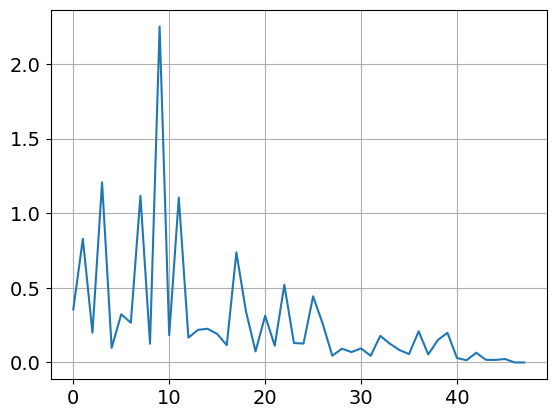

In [14]:
plt.plot(mode_df['w']/mode_df['sigma'])
plt.grid(True)

In [13]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def nested_partition_to_nifti(args, idx_mode, X):
    in_files = []
    parcels = parcels_img.numpy()
    for idx_level, x in enumerate(X):
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx]+1)
        
        file = f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_level-{idx_level}_desc-partition.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)
        
    out_file = f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_desc-partition.nii.gz'
    concatenate(in_files, out_file)
    return None

def partition_to_nifti(args, idx_mode, x):
    parcels = parcels_img.numpy()
    x_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        x_img += (parcels == roi) * (x[idx]+1)
    
    parcels_img.new_image_like(x_img).to_filename(
        f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_desc-partition.nii.gz'
    )

def overlapping_partition_to_nifti(args, idx_mode, X):
    in_files = []
    parcels = parcels_img.numpy()
    for idx_group, x in enumerate(X.T):
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx])
        
        file = f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_group-{idx_group}_desc-partition.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)
    
    out_file = f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_desc-partition.nii.gz'

    concatenate(in_files, out_file)
    return None

In [14]:
if args.sbm in ['h']:
    for idx_mode, row in mode_df.iterrows():
        nested_partition_to_nifti(args, idx_mode, row['partition'])
elif args.sbm in ['a', 'd']:
    for idx_mode, row in mode_df.iterrows():
        partition_to_nifti(args, idx_mode, row['partition'])
elif args.sbm in ['o']:
    for idx_mode, row in mode_df.iterrows():
        overlapping_partition_to_nifti(args, idx_mode, row['partition'])

240410-18:26:29,29 nipype.interface INFO:
	 stderr 2024-04-10T18:26:29.029619:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240410-18:26:29,32 nipype.interface INFO:
	 stderr 2024-04-10T18:26:29.032461:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240410-18:26:29,39 nipype.interface INFO:
	 stderr 2024-04-10T18:26:29.038996:*+ WARNING: Set TR of output dataset to 1.0 s
240410-18:26:29,114 nipype.interface INFO:
	 stderr 2024-04-10T18:26:29.114513:++ elapsed time = 0.1 s
